## Homework #2
Due 9/23/2024

In [1]:
import numpy as np
import cv2
import os
from matplotlib import pyplot as plt
from scipy.signal import convolve2d
import math

## Problem 1
Define a function to implement the peak-signal-to-noise calculation as described in lecture 4.  

Note: In python functions have the form:

In [2]:
def pSNR(original, reconstructed):
    # ensure images are the same size
    assert original.shape == reconstructed.shape, "Images must have the same dimensions"

    # Calculate MSE
    mse = np.mean((original - reconstructed) ** 2)

    # Max pixel value for 8-bit images
    max_pval = 255.0

    # Calculate PSNR
    result = 10 * np.log10((max_pval ** 2) / mse)
    return result

## Problem 2
* a) Implement a spatial frequency low-pass filter at 1/3 the Nyquist frequency of the image using a top-hat window (e.g. binary 0/1)
* b) Calculate the peak-SNR comparing the two images
* c) Use any image you like.  Put the image in the data folder for this repo 

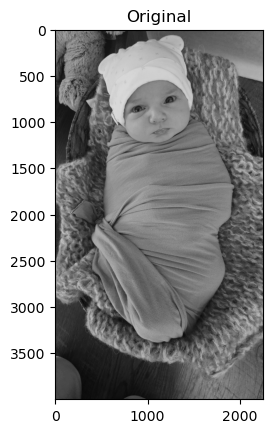

In [3]:
# read in the image
img = cv2.imread(os.path.relpath('Data/simon.jpg'), cv2.IMREAD_COLOR)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# show the image
fig, ax = plt.subplots()
ax.imshow(img, cmap='gray', vmin=0, vmax=255)
ax.set_title('Original')
plt.show()

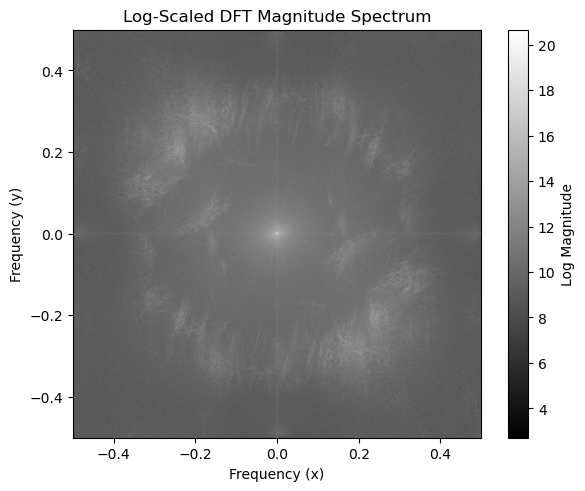

In [4]:
# compute the DFT of the image
dft = np.fft.fft2(img)

# shift zero frequency to the center
dft_shifted = np.fft.fftshift(dft)

# compute the magnitude
dft_mag = np.abs(dft_shifted)

# apply logarithmic transformation to compress the dynamic range
dft_log = np.log(dft_mag + 1)  # Add 1 to avoid log(0)

# calculate the requency bins for both axes
rows, cols = img.shape
freq_y = np.fft.fftshift(np.fft.fftfreq(rows)) # bins for y axis
freq_x = np.fft.fftshift(np.fft.fftfreq(cols)) # bins for the x-axis

# show the result
fig, ax = plt.subplots(layout='constrained')
plot = ax.imshow(dft_log, cmap='gray', extent=(freq_x[0], freq_x[-1], freq_y[0], freq_y[-1]))
ax.set_xlabel('Frequency (x)')
ax.set_ylabel('Frequency (y)')
ax.set_title('Log-Scaled DFT Magnitude Spectrum')
fig.colorbar(plot, ax=ax, label='Log Magnitude')
plt.savefig('Data/DFT.png', bbox_inches='tight')
plt.show()

In [5]:
# compute the spatial Nyquist frequencies
nyq_x = cols / 2
nyq_y = rows / 2

print(f'The Nyquist frequency in the x-direction is {nyq_x}')
print(f'The Nyquist frequency in the y-direction is {nyq_y}')

The Nyquist frequency in the x-direction is 1126.0
The Nyquist frequency in the y-direction is 2000.0


In [6]:
# compute the cutoff frequencies
cutoff_x = nyq_x / 3
cutoff_y = nyq_y / 3

print(f'The cutoff frequency in the x-direction is {cutoff_x:.2f}')
print(f'The cutoff frequency in the y-direction is {cutoff_y:.2f}')

The cutoff frequency in the x-direction is 375.33
The cutoff frequency in the y-direction is 666.67


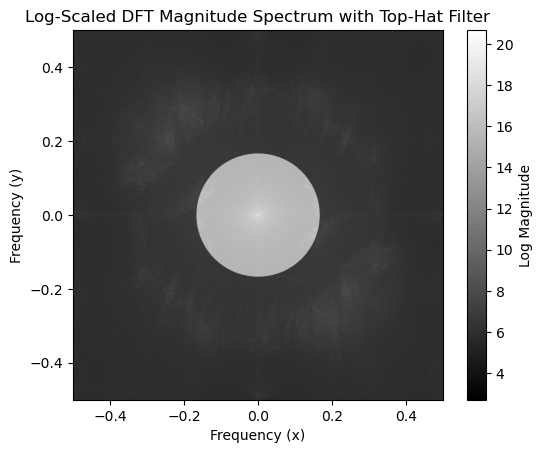

In [7]:
# create a mask of 0s to be filled in later
th_filter = np.zeros((rows, cols), dtype=np.uint8)

# find the center of the frequency domain (i.e., the image center)
center_x, center_y = cols // 2, rows // 2

# draw an ellipse and fill it in with 1s, note modifies in-place
cv2.ellipse(th_filter, (center_x, center_y), (int(cutoff_x), int(cutoff_y)), 0, 0, 360, 1, -1)

# show the filter on the DFT
fig, ax = plt.subplots()
plot = ax.imshow(dft_log, cmap='gray', extent=(freq_x[0], freq_x[-1], freq_y[0], freq_y[-1]))
ax.set_xlabel('Frequency (x)')
ax.set_ylabel('Frequency (y)')
ax.set_title('Log-Scaled DFT Magnitude Spectrum with Top-Hat Filter')
fig.colorbar(plot, ax=ax, label='Log Magnitude')

# Overlay the top-hat filter on top of the DFT
ax.imshow(th_filter, cmap='gray', alpha=0.5, extent=(freq_x[0], freq_x[-1], freq_y[0], freq_y[-1]))  # Set transparency with 'alpha'
plt.savefig('Data/top-hat_filter.png', bbox_inches='tight')
plt.show()

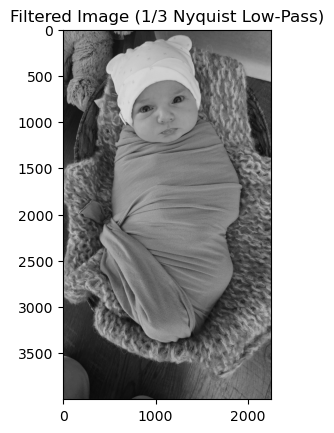

In [8]:
# apply top-hat filter to DFT
filtered_dft = dft_shifted * th_filter

# shift the zero frequency from the center back to the top left corner
filtered_dft_shift_back = np.fft.ifftshift(filtered_dft)

# compute the IDFT
filtered_img = np.fft.ifft2(filtered_dft_shift_back)

# get the real part of the image
filtered_img = np.abs(filtered_img)

# show the reconstructed image
fig, ax = plt.subplots()
ax.imshow(filtered_img, cmap='gray', vmin=0, vmax=255)
ax.set_title('Filtered Image (1/3 Nyquist Low-Pass)')
plt.savefig('Data/reconstructed.png', bbox_inches='tight')
plt.show()

In [9]:
PSNR = pSNR(img, filtered_img)
print(f'The PSNR is {PSNR:.2f} dB')

The PSNR is 24.08 dB


## Problem 3
Implement a similar low-pass filter as problem 2 (1/3 the Nyquist) in the spatial domain as a kernel convolution (e.g. using the sinc function definitions in lecture 5).  Use a top-hat window (e.g. without worrying about tapering the edges).  Use the same image you used in problem 2. 

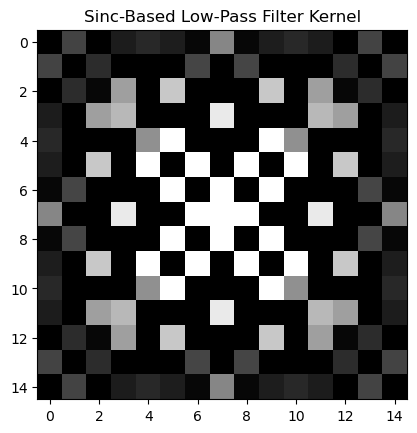

In [10]:
# define the kernel size, center, and initalize the kernel (i.e., make 0s)
kernel_size = 15
kernel_center = kernel_size // 2
kernel = np.zeros((kernel_size, kernel_size), dtype=np.float64)

# Since image is rectangular, take the min cutoff frequency
cutoff_freq = min(cutoff_x, cutoff_y)

# create a range of x and y values, and then make a grid
x = np.arange(-kernel_center, kernel_center + 1)
y = x # since square
X, Y = np.meshgrid(x, y)

# compute the radial distances
r = np.sqrt(X**2 + Y**2)

# use sinc for the kernel
kernel = np.sinc(2 * cutoff_freq * r)
kernel /= np.sum(kernel) # normalize so the sum of the kernel equals 1

# show the kernel
fig, ax = plt.subplots()
ax.imshow(kernel, cmap='gray', vmin=0, vmax=0.0001) # low vmax to see small oscillations
ax.set_title('Sinc-Based Low-Pass Filter Kernel')
plt.savefig('Data/sinc_kernel.png', bbox_inches='tight')
plt.show()

In [11]:
filtered_img = convolve2d(img, kernel, mode='same', boundary='fill', fillvalue=0)

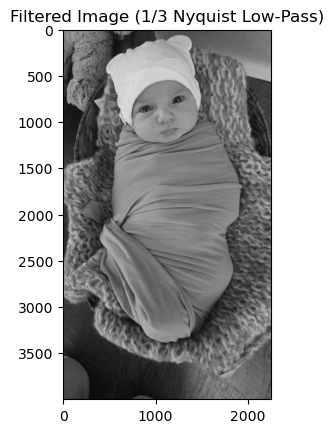

In [12]:
fig, ax = plt.subplots()
ax.imshow(filtered_img, cmap='gray', vmin=0, vmax=255)
ax.set_title('Filtered Image (1/3 Nyquist Low-Pass)')
plt.savefig('Data/kernel_reconstructed.png', bbox_inches='tight')
plt.show()

In [13]:
PSNR = pSNR(img, filtered_img)
print(f'The PSNR is {PSNR:.2f} dB')

The PSNR is 87.21 dB


## Problem 4
Define a function to implement a mean smoothing kernel filter.  

[ECE1390]
* As an input to your function, allow the user to select between a arithmatic, geometric, or harmonic mean
* Assume a fixed 3x3 binary morphological kernel 

[ECE 2690]
* As an input to your function, allow the user to select between a arithmatic, geometric, harmonic mean, or contraharmonic mean ("m" should be an input parameter)
* Design your function to allow any arbitary binary morphological kernel 

In [14]:
def mean_smoothing_filter(img, kernel, method='arithmetic', Q=1):
    """
    Apply a mean smoothing filter to an image using a specified binary morphological kernel.

    Parameters:
    - img: 2D numpy array representing the image.
    - kernel: 2D binary morphological kernel.
    - method: 'arithmetic', 'geometric', 'harmonic', or 'contraharmonic'. Specifies the type of mean.
    - Q: Parameter for contraharmonic mean (only used if method is 'contraharmonic').

    Returns:
    - smoothed_img: 2D numpy array representing the filtered image.
    """

    # Ensure the kernel is binary
    kernel = kernel.astype(np.float64)
    
    # Kernel sum is used for normalization in some filters
    kernel_sum = np.sum(kernel)
    
    if kernel_sum == 0:
        raise ValueError("The kernel must have a non-zero sum for proper convolution.")

    if method == 'arithmetic':
        # Arithmetic mean filter: sum of pixel values / number of pixels in kernel
        smoothed_img = convolve2d(img, kernel / kernel_sum, mode='same', boundary='fill', fillvalue=0)
    
    elif method == 'geometric':
        # Geometric mean filter: nth root of the product of pixel values in the kernel
        smoothed_img = np.exp(convolve2d(np.log(img), kernel, mode='same', boundary='fill', fillvalue=0) / kernel_sum)
    
    elif method == 'harmonic':
        # Harmonic mean filter: kernel size / sum of reciprocals of pixel values
        smoothed_img = kernel_sum / convolve2d(1 / (img), kernel, mode='same', boundary='fill', fillvalue=0)
    
    elif method == 'contraharmonic':
        # Contraharmonic mean filter: sum of pixel values raised to Q+1 / sum of pixel values raised to Q
        num = convolve2d(np.power(img, Q + 1), kernel, mode='same', boundary='fill', fillvalue=0)
        denom = convolve2d(np.power(img, Q), kernel, mode='same', boundary='fill', fillvalue=0)
        smoothed_img = num / denom
    
    else:
        raise ValueError("Invalid method specified. Choose from 'arithmetic', 'geometric', 'harmonic', or 'contraharmonic'.")
    
    return smoothed_img

### Example

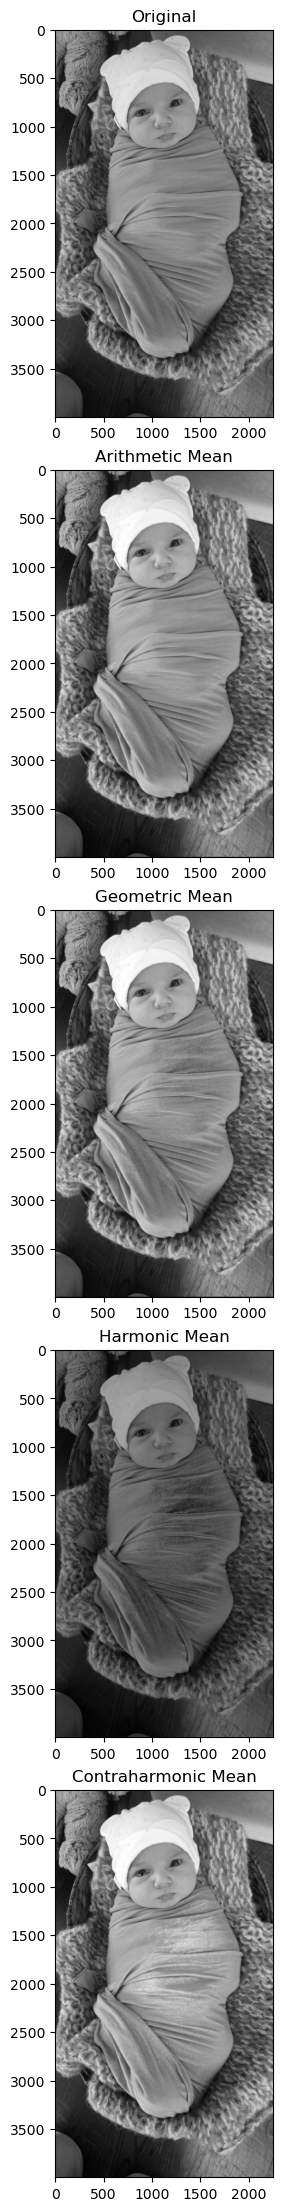

In [15]:
# create a gaussian kernel
size = 19
sigma = 2

g_kern_1D = cv2.getGaussianKernel(size, sigma)
g_kern_2D = g_kern_1D @ g_kern_1D.T

# Apply filters and visualize each one
methods = ['arithmetic', 'geometric', 'harmonic', 'contraharmonic']

fig, axs = plt.subplots(5, 1, figsize=(14, 22), layout='constrained')
axs[0].imshow(img, cmap='gray')
axs[0].set_title('Original')

for i, method in enumerate(methods):
    if method == 'contraharmonic':
        filtered_img = mean_smoothing_filter(img, g_kern_2D, method=method, Q=1.5)  # Q=1.5 for contraharmonic
    else:
        filtered_img = mean_smoothing_filter(img, g_kern_2D, method=method)
    
    axs[i + 1].imshow(filtered_img, cmap='gray')
    axs[i + 1].set_title(f'{method.capitalize()} Mean')
plt.savefig('Data/mean_smoothing_filter_ex.png', bbox_inches='tight')
plt.show()

## Problem 5 [ECE 2390 only]
Define a function to compute the discrete cosine transform of an image.  Include code to pad the image appropriately. The equation for the DCT was given in lecture 4  

In [18]:
def pad_image_to_power_of_2(image):
    """
    Pads an image to the nearest power of 2 dimensions.
    
    Parameters:
    - image: 2D numpy array representing the grayscale image.
    
    Returns:
    - padded_image: The image padded to the nearest power of 2 dimensions.
    """
    N, M = image.shape
    next_pow2_N = 2**int(np.ceil(np.log2(N)))
    next_pow2_M = 2**int(np.ceil(np.log2(M)))
    
    # Pad the image to the nearest power of 2 dimensions
    padded_image = np.pad(image, ((0, next_pow2_N - N), (0, next_pow2_M - M)), mode='constant')
    return padded_image

def dct2_manual(image):
    """
    Compute the 2D Discrete Cosine Transform (DCT) manually, with padding to the nearest power of 2.
    
    Parameters:
    - image: 2D numpy array representing the grayscale image.
    
    Returns:
    - dct_transformed: 2D numpy array containing the DCT coefficients of the padded image.
    """
    # Pad the image to the nearest power of 2 dimensions
    image = pad_image_to_power_of_2(image)
    
    N, M = image.shape  # Get the dimensions of the padded image
    dct_transformed = np.zeros((N, M))

    # Compute the DCT using the mathematical formula
    for u in range(N):
        for v in range(M):
            # Initialize the coefficient for the current DCT entry
            sum_value = 0.0
            for i in range(N):
                for j in range(M):
                    # Cosine term for row (i) and column (j)
                    sum_value += image[i, j] * math.cos(((2 * i + 1) * u * math.pi) / (2 * N)) * math.cos(((2 * j + 1) * v * math.pi) / (2 * M))

            # Apply the normalization factors based on the formula
            alpha_u = math.sqrt(1 / N) if u == 0 else math.sqrt(2 / N)
            alpha_v = math.sqrt(1 / M) if v == 0 else math.sqrt(2 / M)

            # Set the transformed coefficient (DCT value for (u, v))
            dct_transformed[u, v] = alpha_u * alpha_v * sum_value

    return dct_transformed

In [ ]:
dct_result = dct2_manual(img)